In [54]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import random

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

import pandas as pd
import seaborn as sns
import scipy.stats as st

In [55]:
#To visualize the whole grid
pd.options.display.max_columns = 999

def adj_r2_score(y_test, y_pred, X_test):
    num = (1-r2_score(y_test, y_pred)) * (len(X_test)-1)
    den = (len(X_test)-len(X_test.columns)-1)
    return 1 - (num / den)

def normalize(data):
    x = data
    x = (x - x.mean()) / x.std()
    return x

def writecsv(filename, data):
    with open(filename, "w") as csvFile: 
        csvFile.write("Id,SalePrice\n")
        idCounter = 0
        for price in data:
            csvFile.write(str(test.index[idCounter]) + "," + str(price) + "\n")
            idCounter = idCounter + 1

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000


In [48]:
#Kaggle divides the dataset already into Train and Test data
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

train_data = train.copy(deep=True)
test_data = test.copy(deep=True)
# Remove outliers based on SalePrice and GrLivArea
# train_data = train.drop(index=[692, 1183, 1299, 524], axis=0)
# train_data = train_data.loc[train_data.HouseStyle != "2.5Fin"]
# if house has a pool with an area greater than 0 then 1 else zero
# train_data['Pool'] = train_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
# Remodeled indicator
# train_data['Remodeled'] = np.where(train_data.YearBuilt != train_data.YearRemodAdd, 1, 0)

train_data['GrLivArea'] = normalize(train_data.GrLivArea)
train_data['GarageArea'] = normalize(train_data.GarageArea)
train_data['TotalBsmtSF'] = normalize(train_data.TotalBsmtSF)
train_data['LowQualFinSF'] = normalize(train_data.LowQualFinSF)
train_data['KitchenAbvGr'] = normalize(train_data.KitchenAbvGr)

train_data['ExterQual'] = train_data['ExterQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['BsmtQual'] = train_data['BsmtQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['HeatingQC'] = train_data['HeatingQC'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['KitchenQual'] = train_data['KitchenQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['BsmtExposure'] = train_data['BsmtExposure'].replace({'Gd':4,'Av': 3, 'Mn':2, 'No':1, 'NA':0})

test_data['GrLivArea'] = normalize(test_data.GrLivArea)
test_data['GarageArea'] = normalize(test_data.GarageArea)
test_data['TotalBsmtSF'] = normalize(test_data.TotalBsmtSF)
test_data['LowQualFinSF'] = normalize(test_data.LowQualFinSF)
test_data['KitchenAbvGr'] = normalize(test_data.KitchenAbvGr)

test_data['ExterQual'] = test_data['ExterQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['BsmtQual'] = test_data['BsmtQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['HeatingQC'] = test_data['HeatingQC'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['KitchenQual'] = test_data['KitchenQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['BsmtExposure'] = test_data['BsmtExposure'].replace({'Gd':4,'Av': 3, 'Mn':2, 'No':1, 'NA':0})

# drop columns that are not needed
#train_data['OverallCond'] = train_data['OverallCond'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else 2))
train_data['LowQualFinSF'] = train_data['LowQualFinSF'].apply(lambda x: 0 if x == 0 else 1)
train_data['Bath'] = train_data['HalfBath'] + train_data['FullBath']
train_data['Electrical'] = train_data['Electrical'].apply(lambda x: 'Brk' if x == 'SBrkr' else 'Fuse')
train_data['SaleType'] = train_data['SaleType'].apply(lambda x: 'New' if x == 'New' else 'Not_New')
train_data['SaleCondition'] = train_data['SaleCondition'].apply(lambda x: 'Partial' if x == 'Partial' else 'Not_Partial')

#test_data['OverallCond'] = test_data['OverallCond'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else 2))
test_data['LowQualFinSF'] = test_data['LowQualFinSF'].apply(lambda x: 0 if x == 0 else 1)
test_data['Bath'] = test_data['HalfBath'] + test_data['FullBath']
test_data['Electrical'] = test_data['Electrical'].apply(lambda x: 'Brk' if x == 'SBrkr' else 'Fuse')
test_data['SaleType'] = test_data['SaleType'].apply(lambda x: 'New' if x == 'New' else 'Not_New')
test_data['SaleCondition'] = test_data['SaleCondition'].apply(lambda x: 'Partial' if x == 'Partial' else 'Not_Partial')

# Covert categorical variables into usable terms
train_data = pd.get_dummies(data=train_data, dummy_na=False, columns=[
    'Alley',
    'HouseStyle',
    'Foundation',
    'CentralAir',
    'Electrical',
    'GarageType',
    'GarageFinish',
    'SaleType',
    'SaleCondition'
    ])

test_data = pd.get_dummies(data=test_data, dummy_na=False, columns=[
    'Alley',
    'HouseStyle',
    'Foundation',
    'CentralAir',
    'Electrical',
    'GarageType',
    'GarageFinish',
    'SaleType',
    'SaleCondition'
    ])

train_data['GarageArea'].fillna(0, inplace=True)
train_data['TotalBsmtSF'].fillna(0, inplace=True)
train_data['BsmtQual'].fillna(0, inplace=True)
train_data['BsmtExposure'].fillna(0, inplace=True)
train_data['KitchenQual'].fillna(0, inplace=True)

test_data['GarageArea'].fillna(0, inplace=True)
test_data['TotalBsmtSF'].fillna(0, inplace=True)
test_data['BsmtQual'].fillna(0, inplace=True)
test_data['BsmtExposure'].fillna(0, inplace=True)
test_data['KitchenQual'].fillna(0, inplace=True)

train_labels = train_data.SalePrice


# LotFrontage - Linear feet of street connected to property - set to 0
# train_data['LotFrontage'].fillna(0, inplace=True)
# MasVnrArea - Masonry veneer area in square feet - set to 0
# train_data['MasVnrArea'].fillna(0, inplace=True)
# GarageYrBlt - Year garage was built - set to average garage year build
# train_data['GarageYrBlt'].fillna(train_data['GarageYrBlt'].mean(), inplace=True)
#train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2)
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SalePrice,Bath,Alley_Grvl,Alley_Pave,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,CentralAir_N,CentralAir_Y,Electrical_Brk,Electrical_Fuse,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,SaleType_New,SaleType_Not_New,SaleCondition_Not_Partial,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,5,TA,5.0,TA,4.0,GLQ,5644,Unf,0,466,11.517003,GasA,5,4692,950,1,7.852884,2,0,2,1,3,-0.211381,5,12,Typ,3,Gd,2008.0,2,4.420012,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,160000,3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1
524,60,RL,130.0,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,5,TA,5.0,TA,4.0,GLQ,2260,Unf,0,878,4.742524,GasA,5,3138,1538,1,6.014566,1,0,3,1,3,-0.211381,5,11,Typ,1,Gd,2007.0,3,1.922407,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,184750,4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1
1183,60,RL,160.0,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,4,TA,5.0,TA,3.0,GLQ,2096,Unf,0,300,3.051184,GasA,5,2411,2065,1,5.633962,1,0,3,1,4,-0.211381,5,10,Typ,2,TA,1996.0,3,1.590328,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,745000,4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0
692,60,RL,104.0,21535,Pave,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,5,TA,5.0,TA,4.0,GLQ,1455,Unf,0,989,3.160597,GasA,5,2444,1872,1,5.329478,0,1,3,1,4,-0.211381,5,10,Typ,2,Ex,1994.0,3,1.679194,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,755000,4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0
1170,60,RL,118.0,35760,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,4,Gd,5.0,TA,4.0,GLQ,1387,Unf,0,543,1.988967,GasA,5,1831,1796,1,4.018297,1,0,3,1,4,-0.211381,4,10,Typ,1,TA,1995.0,3,1.562265,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,625000,4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0


In [49]:
train_data = pd.concat([
    train_data.OverallQual,
    train_data.GrLivArea,
    train_data.GarageArea,
    train_data.YearBuilt,
    train_data.YearRemodAdd,
    train_data.OverallCond,
    train_data.TotalBsmtSF,
    train_data.LowQualFinSF,
    train_data.Bath, 
    train_data.KitchenAbvGr,
    train_data.Fireplaces,
    train_data.Alley_Grvl,
    train_data.Alley_Pave,
    train_data['HouseStyle_1.5Fin'],
    train_data['HouseStyle_1Story'],
    train_data['HouseStyle_2Story'],
    train_data['HouseStyle_SLvl'],
    train_data['HouseStyle_SFoyer'],
    train_data['HouseStyle_1.5Unf'],
    train_data['HouseStyle_2.5Unf'],
    train_data.ExterQual,
    train_data.Foundation_PConc,
    train_data.Foundation_CBlock,
    train_data.Foundation_BrkTil,
    train_data.Foundation_Slab,
    train_data.Foundation_Stone,
    train_data.Foundation_Wood,
    train_data.BsmtQual,
    train_data.BsmtExposure,
    train_data.HeatingQC,
    train_data.CentralAir_Y,
    train_data.CentralAir_N,
    train_data.Electrical_Brk,
    train_data.Electrical_Fuse,
    train_data.KitchenQual,
    train_data.GarageType_Attchd,
    train_data.GarageType_Detchd,
    train_data.GarageType_BuiltIn,
    train_data.GarageType_Basment,
    train_data.GarageType_2Types,
    train_data.GarageType_CarPort,
    train_data.GarageFinish_Unf,
    train_data.GarageFinish_Fin,
    train_data.GarageFinish_RFn,
    train_data.SaleType_New,
    train_data.SaleType_Not_New,
    train_data.SaleCondition_Partial,
    train_data.SaleCondition_Not_Partial
    ], axis=1)
test_data = pd.concat([
    test_data.OverallQual,
    test_data.GrLivArea,
    test_data.GarageArea,
    test_data.YearBuilt,
    test_data.YearRemodAdd,
    test_data.OverallCond,
    test_data.TotalBsmtSF,
    test_data.LowQualFinSF,
    test_data.Bath, 
    test_data.KitchenAbvGr,
    test_data.Fireplaces,
    test_data.Alley_Grvl,
    test_data.Alley_Pave,
    test_data['HouseStyle_1.5Fin'],
    test_data['HouseStyle_1Story'],
    test_data['HouseStyle_2Story'],
    test_data['HouseStyle_SLvl'],
    test_data['HouseStyle_SFoyer'],
    test_data['HouseStyle_1.5Unf'],
    test_data['HouseStyle_2.5Unf'],
    test_data.ExterQual,
    test_data.Foundation_PConc,
    test_data.Foundation_CBlock,
    test_data.Foundation_BrkTil,
    test_data.Foundation_Slab,
    test_data.Foundation_Stone,
    test_data.Foundation_Wood,
    test_data.BsmtQual,
    test_data.BsmtExposure,
    test_data.HeatingQC,
    test_data.CentralAir_Y,
    test_data.CentralAir_N,
    test_data.Electrical_Brk,
    test_data.Electrical_Fuse,
    test_data.KitchenQual,
    test_data.GarageType_Attchd,
    test_data.GarageType_Detchd,
    test_data.GarageType_BuiltIn,
    test_data.GarageType_Basment,
    test_data.GarageType_2Types,
    test_data.GarageType_CarPort,
    test_data.GarageFinish_Unf,
    test_data.GarageFinish_Fin,
    test_data.GarageFinish_RFn,
    test_data.SaleType_New,
    test_data.SaleType_Not_New,
    test_data.SaleCondition_Partial,
    test_data.SaleCondition_Not_Partial
    ], axis=1)

print(train_data.isna().any()[lambda x: x])
print(test_data.isna().any()[lambda x:x])

#corr = train_data.corr(method = 'pearson')
#f, ax = plt.subplots(figsize=(12,9))
#sns.heatmap(corr, square = True, cmap ="YlGnBu")

Series([], dtype: bool)
Series([], dtype: bool)


In [45]:
# Root Square Mean Error 21509.08
lr = LinearRegression()
lr.fit(train_data, np.log(train_labels))
predicted_labels = lr.predict(test_data)
writecsv("submission.csv", np.exp(predicted_labels))

#rmse = np.sqrt(mean_squared_error(test_labels, np.exp(predicted_labels)))
#r2 = r2_score(test_labels, np.exp(predicted_labels))
#print('Root Square Mean Error ' + str(round(rmse, 2)))
#print('R-Squared ' + str(round(r2, 3)))
#print('Adj R-Squared ' + str(round(adj_r2_score(test_labels, np.exp(predicted_labels), test_data), 3)))

In [72]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

train_data = train.copy(deep=True)
test_data = test.copy(deep=True)

train_data['GrLivArea'] = normalize(train_data.GrLivArea)
train_data['GarageArea'] = normalize(train_data.GarageArea)
train_data['TotalBsmtSF'] = normalize(train_data.TotalBsmtSF)
train_data['LowQualFinSF'] = normalize(train_data.LowQualFinSF)
train_data['KitchenAbvGr'] = normalize(train_data.KitchenAbvGr)
train_data['LotFrontage'] = normalize(train_data.LotFrontage)
train_data['LotArea'] = normalize(train_data.LotArea)
train_data['MasVnrArea'] = normalize(train_data.MasVnrArea)
train_data['BsmtFinSF1'] = normalize(train_data.BsmtFinSF1)
train_data['BsmtFinSF2'] = normalize(train_data.BsmtFinSF2)
train_data['1stFlrSF'] = normalize(train_data['1stFlrSF'])
train_data['2ndFlrSF'] = normalize(train_data['2ndFlrSF'])
train_data['BsmtUnfSF'] = normalize(train_data.BsmtUnfSF)
train_data['WoodDeckSF'] = normalize(train_data.WoodDeckSF)
train_data['OpenPorchSF'] = normalize(train_data.OpenPorchSF)
train_data['EnclosedPorch'] = normalize(train_data.EnclosedPorch)
train_data['3SsnPorch'] = normalize(train_data['3SsnPorch'])
train_data['ScreenPorch'] = normalize(train_data.ScreenPorch)
train_data['PoolArea'] = normalize(train_data.PoolArea)
train_data['MiscVal'] = normalize(train_data.MiscVal)

train_data['ExterQual'] = train_data['ExterQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['BsmtQual'] = train_data['BsmtQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['HeatingQC'] = train_data['HeatingQC'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['KitchenQual'] = train_data['KitchenQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['BsmtExposure'] = train_data['BsmtExposure'].replace({'Gd':4,'Av': 3, 'Mn':2, 'No':1, 'NA':0})
train_data['ExterCond'] = train_data['ExterCond'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['BsmtCond'] = train_data['BsmtCond'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['FireplaceQu'] = train_data['FireplaceQu'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['GarageQual'] = train_data['GarageQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['GarageCond'] = train_data['GarageCond'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
train_data['PoolQC'] = train_data['PoolQC'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})

test_data['GrLivArea'] = normalize(test_data.GrLivArea)
test_data['GarageArea'] = normalize(test_data.GarageArea)
test_data['TotalBsmtSF'] = normalize(test_data.TotalBsmtSF)
test_data['LowQualFinSF'] = normalize(test_data.LowQualFinSF)
test_data['KitchenAbvGr'] = normalize(test_data.KitchenAbvGr)
test_data['LotFrontage'] = normalize(test_data.LotFrontage)
test_data['LotArea'] = normalize(test_data.LotArea)
test_data['MasVnrArea'] = normalize(test_data.MasVnrArea)
test_data['BsmtFinSF1'] = normalize(test_data.BsmtFinSF1)
test_data['BsmtFinSF2'] = normalize(test_data.BsmtFinSF2)
test_data['1stFlrSF'] = normalize(test_data['1stFlrSF'])
test_data['2ndFlrSF'] = normalize(test_data['2ndFlrSF'])
test_data['BsmtUnfSF'] = normalize(test_data.BsmtUnfSF)
test_data['WoodDeckSF'] = normalize(test_data.WoodDeckSF)
test_data['OpenPorchSF'] = normalize(test_data.OpenPorchSF)
test_data['EnclosedPorch'] = normalize(test_data.EnclosedPorch)
test_data['3SsnPorch'] = normalize(test_data['3SsnPorch'])
test_data['ScreenPorch'] = normalize(test_data.ScreenPorch)
test_data['PoolArea'] = normalize(test_data.PoolArea)
test_data['MiscVal'] = normalize(test_data.MiscVal)

test_data['ExterQual'] = test_data['ExterQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['BsmtQual'] = test_data['BsmtQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['HeatingQC'] = test_data['HeatingQC'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['KitchenQual'] = test_data['KitchenQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['BsmtExposure'] = test_data['BsmtExposure'].replace({'Gd':4,'Av': 3, 'Mn':2, 'No':1, 'NA':0})
test_data['ExterCond'] = test_data['ExterCond'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['BsmtCond'] = test_data['BsmtCond'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['FireplaceQu'] = test_data['FireplaceQu'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['GarageQual'] = test_data['GarageQual'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['GarageCond'] = test_data['GarageCond'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
test_data['PoolQC'] = test_data['PoolQC'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})

# drop columns that are not needed
#train_data['OverallCond'] = train_data['OverallCond'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else 2))
train_data['LowQualFinSF'] = train_data['LowQualFinSF'].apply(lambda x: 0 if x == 0 else 1)
#train_data['Bath'] = train_data['HalfBath'] + train_data['FullBath']
train_data['Electrical'] = train_data['Electrical'].apply(lambda x: 'Brk' if x == 'SBrkr' else 'Fuse')
train_data['SaleType'] = train_data['SaleType'].apply(lambda x: 'New' if x == 'New' else 'Not_New')
train_data['SaleCondition'] = train_data['SaleCondition'].apply(lambda x: 'Partial' if x == 'Partial' else 'Not_Partial')

#test_data['OverallCond'] = test_data['OverallCond'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else 2))
test_data['LowQualFinSF'] = test_data['LowQualFinSF'].apply(lambda x: 0 if x == 0 else 1)
#test_data['Bath'] = test_data['HalfBath'] + test_data['FullBath']
test_data['Electrical'] = test_data['Electrical'].apply(lambda x: 'Brk' if x == 'SBrkr' else 'Fuse')
test_data['SaleType'] = test_data['SaleType'].apply(lambda x: 'New' if x == 'New' else 'Not_New')
test_data['SaleCondition'] = test_data['SaleCondition'].apply(lambda x: 'Partial' if x == 'Partial' else 'Not_Partial')

# Covert categorical variables into usable terms
train_data = pd.get_dummies(data=train_data, dummy_na=False, columns=[
    'Alley',
    'MSZoning',
    'Street',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'Functional',
    'PavedDrive',
    'Fence',
    'MiscFeature',
    'HouseStyle',
    'Foundation',
    'CentralAir',
    'Electrical',
    'GarageType',
    'GarageFinish',
    'SaleType',
    'SaleCondition'
    ])

test_data = pd.get_dummies(data=test_data, dummy_na=False, columns=[
    'Alley',
    'MSZoning',
    'Street',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'Functional',
    'PavedDrive',
    'Fence',
    'MiscFeature',
    'HouseStyle',
    'Foundation',
    'CentralAir',
    'Electrical',
    'GarageType',
    'GarageFinish',
    'SaleType',
    'SaleCondition'
    ])

train_data['GarageArea'].fillna(0, inplace=True)
train_data['TotalBsmtSF'].fillna(0, inplace=True)
train_data['BsmtQual'].fillna(0, inplace=True)
train_data['BsmtExposure'].fillna(0, inplace=True)
train_data['KitchenQual'].fillna(0, inplace=True)
train_data['MasVnrArea'].fillna(0, inplace=True)
train_data['BsmtCond'].fillna(0, inplace=True)
train_data['FireplaceQu'].fillna(0, inplace=True)
train_data['GarageYrBlt'].fillna(0, inplace=True)
train_data['GarageQual'].fillna(0, inplace=True)
train_data['GarageCond'].fillna(0, inplace=True)
train_data['PoolQC'].fillna(0, inplace=True)
train_data['LotFrontage'].fillna(0, inplace=True)

test_data['GarageArea'].fillna(0, inplace=True)
test_data['TotalBsmtSF'].fillna(0, inplace=True)
test_data['BsmtQual'].fillna(0, inplace=True)
test_data['BsmtExposure'].fillna(0, inplace=True)
test_data['KitchenQual'].fillna(0, inplace=True)
test_data['LotFrontage'].fillna(0, inplace=True)
test_data['MasVnrArea'].fillna(0, inplace=True)
test_data['BsmtCond'].fillna(0, inplace=True)
test_data['BsmtFinSF1'].fillna(0, inplace=True)
test_data['BsmtFinSF2'].fillna(0, inplace=True)
test_data['BsmtUnfSF'].fillna(0, inplace=True)
test_data['BsmtFullBath'].fillna(0, inplace=True)
test_data['BsmtHalfBath'].fillna(0, inplace=True)
test_data['FireplaceQu'].fillna(0, inplace=True)
test_data['GarageYrBlt'].fillna(0, inplace=True)
test_data['GarageCars'].fillna(0, inplace=True)
test_data['GarageQual'].fillna(0, inplace=True)
test_data['GarageCond'].fillna(0, inplace=True)
test_data['PoolQC'].fillna(0, inplace=True)

train_labels = train_data.SalePrice
train_data.drop([
    'SalePrice',
    'MSSubClass',
    'HouseStyle_2.5Fin',
    'Utilities_NoSeWa',
    'Condition2_RRAe',
    'Condition2_RRAn',
    'Condition2_RRNn',
    'RoofMatl_ClyTile',
    'RoofMatl_Membran',
    'RoofMatl_Metal',
    'RoofMatl_Roll',
    'Exterior1st_ImStucc',
    'Exterior1st_Stone',
    'Exterior2nd_Other',
    'Heating_Floor',
    'Heating_OthW',
    'MiscFeature_TenC'], axis=1, inplace=True)

test_data.drop(['MSSubClass'], axis=1, inplace=True)
# LotFrontage - Linear feet of street connected to property - set to 0
# train_data['LotFrontage'].fillna(0, inplace=True)
# MasVnrArea - Masonry veneer area in square feet - set to 0
# train_data['MasVnrArea'].fillna(0, inplace=True)
# GarageYrBlt - Year garage was built - set to average garage year build
# train_data['GarageYrBlt'].fillna(train_data['GarageYrBlt'].mean(), inplace=True)
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2)
for col in train_data.columns:
    if col not in test_data.columns:
        print(col)


In [73]:
print(train_data.isna().any()[lambda x: x])
print(test_data.isna().any()[lambda x:x])

features = train_data.columns
encv = ElasticNetCV(eps=1e-5)
encv.fit(train_data, np.log(train_labels))
predicted_labels = encv.predict(test_data)

rmse = np.sqrt(mean_squared_error(test_labels, np.exp(predicted_labels)))
#r2 = r2_score(test_labels, np.exp(predicted_labels))
print('Root Square Mean Error ' + str(round(rmse, 2)))
#print('R-Squared ' + str(round(r2, 3)))
print('Adj R-Squared ' + str(round(adj_r2_score(test_labels, np.exp(predicted_labels), test_data), 3)))

#writecsv("submission.csv", np.exp(predicted_labels))
print("ElasticNetCV regression has conserved %d features over %d"%(len(features[encv.coef_!=0]), train_data.shape[1]))
#for feat in features[encv.coef_!=0]:
#    print(feat)

Series([], dtype: bool)
Series([], dtype: bool)
Root Square Mean Error 21577.59
Adj R-Squared 0.635
ElasticNetCV regression has conserved 111 features over 221


## Baseline Model

The base line model was a linear regession model a few variables `GrLivArea`, `YearBuilt`, `OverallQual`. The RMSE is 57365.84.

In [77]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

train_data = train[:1000]
train_labels = train.SalePrice[:1000]
dev_data = train[1000:]
dev_labels = train.SalePrice[1000:]

x = train_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual']]
y = np.log(train_labels)
lr = LinearRegression()
lr.fit(x, y)
y_predicted = lr.predict(dev_data.loc[:, ['GrLivArea', 'YearBuilt', 'OverallQual']])
rmse = np.sqrt(mean_squared_error(dev_labels, np.exp(y_predicted)))
adj_r2 = adj_r2_score(dev_labels, np.exp(y_predicted), dev_data)
print(rmse)
print(adj_r2)
#rmse = np.sqrt(mean_squared_error(test_labels, np.exp(predicted_labels)))
#writecsv("submission.csv", np.exp(predicted_labels))

20681.727966991115
0.38375695873685267


## Predicitive Accuracy First Approach

For my first appach I wanted to look at all the variables and make visual determinations about if the variable had a significant impact on on the houses sale price. I conducted this analysis using boxplots and scatterplots.

Plot 1 below is an example of the visual analysis done for the categorical variable `HeatingQC`. The boxplot show that each heating quality rating has a fairly different median `SalePrice`. This means that `HeatingQC` is potentially a good predictor for sales price.

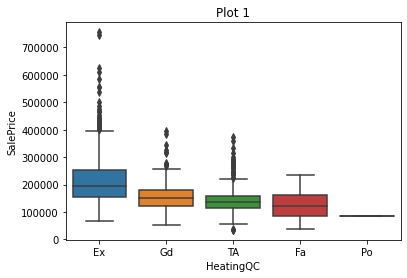

In [129]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)
sns.boxplot(x="HeatingQC", y="SalePrice", data=train).set_title("Plot 1")
plt.show()

Plot 2 is an example of how to analyize numberical variables. We can look for a linear realtionship between `GarageArea` and `SalePrice` to determine if would be a good predictor of SalesPrice. We also utilized the Hue argument of the scatterplot to add another dimension to this analysis. Adding `GarageCars` to this graph allows us to see the number of cars that fit in the garage of a particular size and how that correlates with `SalePrice`.

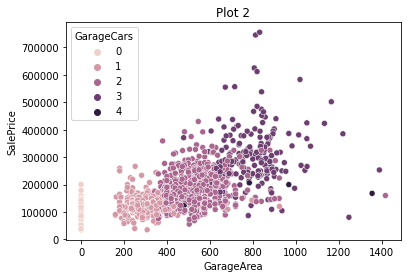

In [127]:
sns.scatterplot(x='GarageArea', y='SalePrice', data=train, hue='GarageCars').set_title("Plot 2")
plt.show() 

Using these techniques allowed me to select variables that are good predictors of `SalePrice`. Once these variables were selected I used pearson correlation to eliminate some variables base on high correlation with one another. As you can see in Plot 3 `GarageCars` and `GarageArea` are higly correlated so only one should be incorperated into the final model.

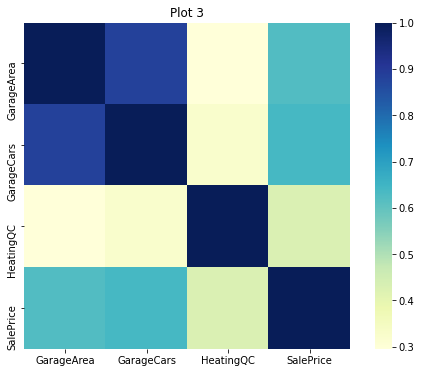

In [141]:
tmp_tbl = train[['GarageArea', 'GarageCars', 'HeatingQC', 'SalePrice']]
tmp_tbl['HeatingQC'].replace({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}, inplace=True)
corr = tmp_tbl.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, square = True, cmap ="YlGnBu").set_title("Plot 3")
plt.show()

This process allowed me to reduce the number of variables from 80 to 25.
`OverallQual`, `GrLivArea`, `GarageArea`, `YearBuilt`, `YearRemodAdd`, `OverallCond`,`TotalBsmtSF`, `LowQualFinSF`, `Bath`, `KitchenAbvGr`,`Fireplaces`,`Alley`, `HouseStyle`, `ExterQual`, `Foundation`, `BsmtQual`, `BsmtExposure`, `HeatingQC`, `CentralAir`, `Electrical`, `KitchenQual`, `GarageType`, `GarageFinish`, `SaleType`, `SaleCondition`

Even though my variables have been reduced some of these variables non-numberic so I had to implement one of the following to each non-numberic variables:

1. Create dummy variables - used when variable were non-ordinal
2. Encode the variable - used on ordinal variables

Using the approaches turn my 25 variables into 48. With the new 48 numberic varialbe i replaced 'NaNs' with 0 and used a linear regression. My final results for this approach produced a RMSE of 0.14889

## Predictive Accuracy Second Approach

My second approach involed me do a bit of resarch. In looking through the different types of regression I looked into lasso, Ridge, and ElasticNet. Eventually, I choose ElasticNet since it appears to utilize the strengths of both lasso and Ridge regressions. Then I found and example that used ElasticNetCV (cross validation) so I decided this would be the model I would use for my second approach.